In [1]:
import sqlite3
import pandas as pd
import polars as pl
pd.options.mode.chained_assignment = None

import sys
sys.path.append('../')
sys.path.append('../networks')

from functions.env import  DB_SCIENCE_PATH_NEW, GRAPH_RESULTS

conn = sqlite3.connect(DB_SCIENCE_PATH_NEW)

from functions.datamodel import OptimumParameter
from functions.feat_network import get_edge_node_table
from functions.feat_visualization import sygma_graph_leiden
from optimal_clustering import optimal_clustering

dict_op = optimal_clustering
dict_op = OptimumParameter(**dict_op)

In [2]:
import glob

list_df = []
paths = glob.glob('../networks/data/weighted/*')
for path in paths:
    df = pd.read_csv(path, index_col = [0])
    df = df[['wikidata_id', 'meta_occupation']]
    df['meta_occupation'] = df['meta_occupation'].apply(lambda x: x.split(' | '))
    df = df.explode('meta_occupation')
    df = df.reset_index(drop=True)
    df.columns = ['source', 'target']
    df['weight'] = 1
    list_df.append(df)


In [3]:
from tqdm import tqdm
final_dict = {}

x = 0
for df_net in tqdm(list_df):

    df_net = pl.from_pandas(df_net)
    df_edge, df_nodes = get_edge_node_table(df_net)
    df_edge = df_edge[['source', 'target', 'weight']]
    df_edge['weight'] = (df_edge['weight'] - df_edge['weight'].min()) / (df_edge['weight'].max() - df_edge['weight'].min())
    final_dict[x] = df_edge
    x=x+1

  7%|▋         | 7/100 [00:00<00:01, 61.66it/s]

100%|██████████| 100/100 [00:01<00:00, 68.62it/s]


In [4]:
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


def weighted_jaccard_similarity(matrix1, matrix2):
    """
    Compute the Weighted Jaccard Similarity between two adjacency matrices.
    """
    # Ensure matrices are numpy arrays for element-wise operations
    matrix1 = np.array(matrix1)
    matrix2 = np.array(matrix2)

    # Calculate the minimum (intersection) and maximum (union) for each element
    min_matrix = np.minimum(matrix1, matrix2)
    max_matrix = np.maximum(matrix1, matrix2)

    # Sum the weights for intersection and union
    intersection_weight_sum = np.sum(min_matrix)
    union_weight_sum = np.sum(max_matrix)

    # Compute the similarity
    similarity = intersection_weight_sum / union_weight_sum if union_weight_sum != 0 else 0
    return similarity


def prepare_edge_list(edge1, edge2):

    matrix1 = edge1.pivot(index ='source', columns='target', values='weight')
    matrix1 = matrix1.fillna(0)

    matrix2 = edge2.pivot(index ='source', columns='target', values='weight')
    matrix2 = matrix2.fillna(0)

    labels1 = list(matrix1.index)
    labels2 = list(matrix2.index)
    common_labels = set(labels1).intersection(set(labels2))

    matrix1 = matrix1[common_labels]
    matrix1 = matrix1.reset_index()
    matrix1 = matrix1[matrix1['source'].isin(common_labels)]
    matrix1 = matrix1.set_index('source')

    matrix2 = matrix2[common_labels]
    matrix2 = matrix2.reset_index()
    matrix2 = matrix2[matrix2['source'].isin(common_labels)]
    matrix2 = matrix2.set_index('source')

    matrix1 = matrix1.loc[common_labels, common_labels]
    matrix2 = matrix2.loc[common_labels, common_labels]

    return matrix1, matrix2

In [5]:
# TAKE 4 Minutes

from tqdm import tqdm

datasets = final_dict.copy()
datasets[0]

# Create an empty DataFrame to store the ARI values
ari_df = pd.DataFrame(columns=['Dataset 1', 'Dataset 2', 'metric'])

# Iterate over pairs of datasets and compute the ARI
for dataset1_name, dataset1 in tqdm(datasets.items()):
    for dataset2_name, dataset2 in datasets.items():
        # Get the common elements based on the 'node' column

        dataset1 = dataset1[['source', 'target', 'weight']]
        dataset2 = dataset2[['source', 'target', 'weight']]

        matrix1, matrix2 = prepare_edge_list(dataset1, dataset2)
        matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()

        score = weighted_jaccard_similarity(matrix1.flatten(), matrix2.flatten())
        ari_df = ari_df.append({'Dataset 1': dataset1_name, 'Dataset 2': dataset2_name, 'metric': score}, ignore_index=True)

  3%|▎         | 3/100 [00:11<06:12,  3.84s/it]


KeyboardInterrupt: 

In [ ]:
matrix_df = ari_df.pivot(index='Dataset 1', columns='Dataset 2', values='metric')

0.856659510169097


<AxesSubplot: >

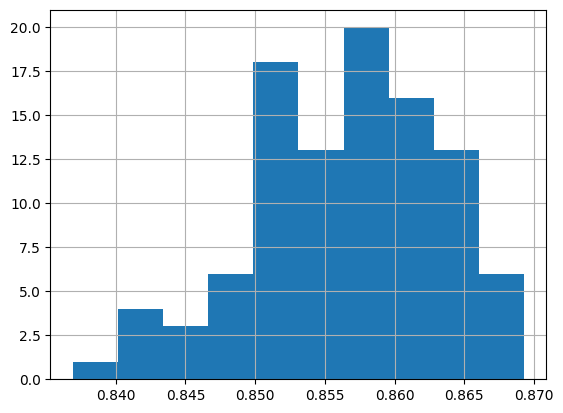

In [ ]:
print(matrix_df.mean().mean())
matrix_df.mean().hist()


#0.856659510169097

In [ ]:
import numpy as np

df_mean = matrix_df.mean().reset_index()
max_val = np.max(df_mean[0])

best_index = df_mean[df_mean[0]==max_val]
best_index = best_index['Dataset 2'].iloc[0]
best_index = int(best_index)
best_index

57

In [ ]:
best_df = list_df[best_index]
df_net = pl.from_pandas(best_df)
df_edge, df_nodes = get_edge_node_table(df_net)
df_edge.to_csv(f"../networks/matrix/weighted_optimized_before_1700.csv")

df_edge_filter = df_edge[df_edge["weight"] >= dict_op.min_count_link]
df_edge_filter = df_edge_filter[
    df_edge_filter["source"] != df_edge_filter["target"]
]

df_edge_filter = df_edge_filter[
    df_edge_filter["rank_count"] <= 3
]

df_edge_filter = df_edge_filter[['source', 'target', 'weight']].copy()


df_partition, g = sygma_graph_leiden(
    df_edge_filter,
    df_nodes,
    edge_bins=10,
    node_bins=10,
    filepath='../graph/best_jaccard.html',
)
df_partition = df_partition.sort_values("community")
df_partition

,community,node
0,0,mathematician
1,0,astronomer
2,0,physicist
3,0,musicologist
4,0,meteorologist
5,0,geographer
6,0,geologist
7,0,chemist
8,0,art theorist
16,1,anthropologist
